In [29]:
import pandas as pd
import numpy as np
import librosa, librosa.display
import matplotlib.pyplot as plt
import matplotlib.style as style
import IPython.display as ipd
import seaborn as sns
from funcs import *

C:\ProgramData\Anaconda3\envs\dsi\lib\site-packages\tqdm\std.py:670: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [4]:
songs = pd.read_csv('./data/five_g_500_modeling.csv')

In [20]:
x, sr = librosa.load(songs.iloc[505]['location'])

X = librosa.stft(x)

H, P = librosa.decompose.hpss(X)

C:\ProgramData\Anaconda3\envs\dsi\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [21]:
Hmag = librosa.amplitude_to_db(H)
Pmag = librosa.amplitude_to_db(P)

C:\ProgramData\Anaconda3\envs\dsi\lib\site-packages\librosa\core\spectrum.py:1642: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  "amplitude_to_db was called on complex input so phase "


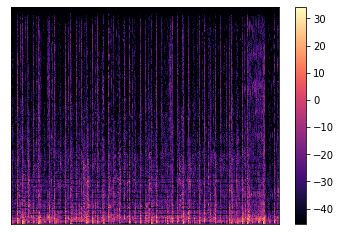

In [22]:
librosa.display.specshow(Pmag)
plt.colorbar();

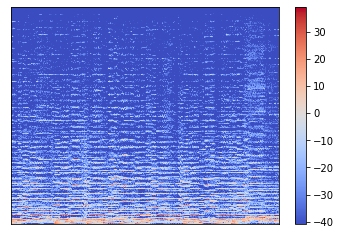

In [23]:
librosa.display.specshow(Hmag)
plt.colorbar();

In [24]:
p = librosa.istft(P)

In [25]:
ipd.Audio(p, rate=44100)

In [30]:
def hpcc_new_features(data, location, hop_length=256, frame_length=512):
    
    # What's the index of the location?
    index = data.index[data['location'] == location].tolist()[0]
    
    # Get the raw audio data
    x, sr = librosa.core.audio.__audioread_load(location, 
                                        offset=0, 
                                        duration=None, 
                                        dtype=np.float32)
    
    # Convert Audio to Mono
    x = librosa.to_mono(x)
    
    # Normalize the raw audio
    x = librosa.util.normalize(x)
    
    X = librosa.stft(x)
    
    H, P = librosa.decompose.hpss(X)
    
    h = librosa.istft(H)
    p = librosa.istft(P)
    
    hop_length = hop_length
    frame_length = frame_length

    # Write data to cell
    data.at[index, 'harm_energy_calc'] = calc_energy(h)
    data.at[index, 'harm_rms_calc'] = calc_rms(h)
    data.at[index, 'harm_mfcc_calc'] = calc_mfcc(h, sr)
    data.at[index, 'perc_energy_calc'] = calc_energy(p)
    data.at[index, 'perc_rms_calc'] = calc_rms(p)
    data.at[index, 'perc_mfcc_calc'] = calc_mfcc(p, sr)

In [27]:
songs['harm_energy_calc'] = np.zeros_like(songs['location'])
songs['harm_rms_calc'] = np.zeros_like(songs['location'])
songs['harm_mfcc_calc'] = np.zeros_like(songs['location'])
songs['perc_energy_calc'] = np.zeros_like(songs['location'])
songs['perc_rms_calc'] = np.zeros_like(songs['location'])
songs['perc_mfcc_calc'] = np.zeros_like(songs['location'])

In [31]:
for location in tqdm(songs['location']):
    hpcc_new_features(songs, location)

100%|██████████| 2500/2500 [2:37:51<00:00,  3.79s/it]  


You can see this took 2h37m51s to run. I don't know if it will be effective, so let's check it out.

In [33]:
def hpss_split_features(data, nfilt=12):
    # I want to split each of the mfcc calculations to their own features    
    harm_mfcc_mean_filters = pd.DataFrame(data['harm_mfcc_mean'].tolist(),
             columns=[f'harm_mfcc_mean_{str(i).zfill(2)}' for i in range(nfilt)])

    harm_mfcc_std_filters = pd.DataFrame(data['harm_mfcc_std'].tolist(),
                 columns=[f'harm_mfcc_std_{str(i).zfill(2)}' for i in range(nfilt)])

    harm_mfcc_min_filters = pd.DataFrame(data['harm_mfcc_min'].tolist(),
                 columns=[f'harm_mfcc_min_{str(i).zfill(2)}' for i in range(nfilt)])

    harm_mfcc_max_filters = pd.DataFrame(data['harm_mfcc_max'].tolist(),
                 columns=[f'harm_mfcc_max_{str(i).zfill(2)}' for i in range(nfilt)])
    
    perc_mfcc_mean_filters = pd.DataFrame(data['perc_mfcc_mean'].tolist(),
             columns=[f'perc_mfcc_mean_{str(i).zfill(2)}' for i in range(nfilt)])

    perc_mfcc_std_filters = pd.DataFrame(data['perc_mfcc_std'].tolist(),
                 columns=[f'perc_mfcc_std_{str(i).zfill(2)}' for i in range(nfilt)])

    perc_mfcc_min_filters = pd.DataFrame(data['perc_mfcc_min'].tolist(),
                 columns=[f'perc_mfcc_min_{str(i).zfill(2)}' for i in range(nfilt)])

    perc_mfcc_max_filters = pd.DataFrame(data['perc_mfcc_max'].tolist(),
                 columns=[f'perc_mfcc_max_{str(i).zfill(2)}' for i in range(nfilt)])
    
    new_df = pd.concat([data, harm_mfcc_mean_filters, 
                           harm_mfcc_std_filters, 
                           harm_mfcc_max_filters, 
                           harm_mfcc_min_filters,
                           perc_mfcc_mean_filters,
                       perc_mfcc_std_filters,
                       perc_mfcc_min_filters,
                       perc_mfcc_max_filters], axis=1)\
                  .drop(columns=['harm_mfcc_calc',
                                'harm_energy_calc',
                                'harm_mfcc_mean',
                                'harm_mfcc_std',
                                'harm_mfcc_min',
                                'harm_mfcc_max',
                                'harm_rms_calc',
                                'perc_mfcc_calc',
                                'perc_energy_calc',
                                'perc_mfcc_mean',
                                'perc_mfcc_std',
                                'perc_mfcc_min',
                                'perc_mfcc_max',
                                'perc_rms_calc'
                                ])
    return new_df

In [36]:
def hpss_calc_features(data):
    data['harm_mean_energy'] = data['harm_energy_calc'].progress_apply(lambda x: x.mean())
    data['harm_std_energy'] = data['harm_energy_calc'].progress_apply(lambda x: x.std())
    data['harm_min_energy'] = data['harm_energy_calc'].progress_apply(lambda x: x.min())
    data['harm_max_energy'] = data['harm_energy_calc'].progress_apply(lambda x: x.max())
    data['harm_mfcc_mean'] = data['harm_mfcc_calc'].apply(lambda x: x.mean(axis=0))
    data['harm_mfcc_std'] = data['harm_mfcc_calc'].apply(lambda x: x.std(axis=0))
    data['harm_mfcc_min'] = data['harm_mfcc_calc'].apply(lambda x: x.min(axis=0))
    data['harm_mfcc_max'] = data['harm_mfcc_calc'].apply(lambda x: x.max(axis=0))
    data['harm_max_rms'] = data['harm_rms_calc'].apply(np.max)
    data['harm_std_rms'] = data['harm_rms_calc'].apply(np.std)
    data['harm_median_rms'] = data['harm_rms_calc'].apply(np.median)
    data['harm_min_rms'] = data['harm_rms_calc'].apply(np.min)
    data['perc_mean_energy'] = data['perc_energy_calc'].progress_apply(lambda x: x.mean())
    data['perc_std_energy'] = data['perc_energy_calc'].progress_apply(lambda x: x.std())
    data['perc_min_energy'] = data['perc_energy_calc'].progress_apply(lambda x: x.min())
    data['perc_max_energy'] = data['perc_energy_calc'].progress_apply(lambda x: x.max())
    data['perc_mfcc_mean'] = data['perc_mfcc_calc'].apply(lambda x: x.mean(axis=0))
    data['perc_mfcc_std'] = data['perc_mfcc_calc'].apply(lambda x: x.std(axis=0))
    data['perc_mfcc_min'] = data['perc_mfcc_calc'].apply(lambda x: x.min(axis=0))
    data['perc_mfcc_max'] = data['perc_mfcc_calc'].apply(lambda x: x.max(axis=0))
    data['perc_max_rms'] = data['perc_rms_calc'].apply(np.max)
    data['perc_std_rms'] = data['perc_rms_calc'].apply(np.std)
    data['perc_median_rms'] = data['perc_rms_calc'].apply(np.median)
    data['perc_min_rms'] = data['perc_rms_calc'].apply(np.min)

In [37]:
hpss_calc_features(songs)

100%|██████████| 2500/2500 [00:00<00:00, 166617.83it/s]


In [40]:
songs_hpss_df = hpss_split_features(songs)

In [50]:
songs_hpss_df.drop(columns=['rms_calc', 'perc_rms_calc', 'harm_rms_calc'], inplace=True)

In [51]:
songs_hpss_df.to_csv('./data/five_g_500_samp_hpss.csv', index=False)